<a href="https://colab.research.google.com/github/JideOkesanjo/Projects/blob/main/store_sales_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import pandas as pd

# Install the Kaggle API
!pip install Kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jide2007","key":"7e94ecaf47b221cf76948e73eab044fd"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!mv kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c store-sales-time-series-forecasting

store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [2]:
datatype = {'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint64'}

In [3]:
sales = pd.read_csv('train.csv', parse_dates=['date'], dtype=datatype, infer_datetime_format=True)

In [4]:
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
sales = sales.drop(['id', 'onpromotion'], axis=1)

In [6]:
sales = sales.set_index('date').to_period('D')
sales = sales.set_index(['store_nbr', 'family'], append=True)
average_sales = sales.groupby('date').mean()['sales']

In [7]:
sales.head()

sales
date       store_nbr family           
2013-01-01 1         AUTOMOTIVE    0.0
                     BABY CARE     0.0
                     BEAUTY        0.0
                     BEVERAGES     0.0
                     BOOKS         0.0

In [8]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
# stored aggregated sales into new dataframe using to_frame method on average_sales variable
df = average_sales.to_frame()

#created a column for time dummy
time = np.arange(len(df.index))

df['time'] = time

X = df.loc[:, ['time']]
y = df.loc[:, 'sales']

model = LinearRegression()

model.fit(X, y)

y_pred = model.predict(X)



In [11]:
y_pred = pd.Series(model.predict(X), index=X.index)

Text(0.5, 1.0, 'Time Plot of Average Store Sales')

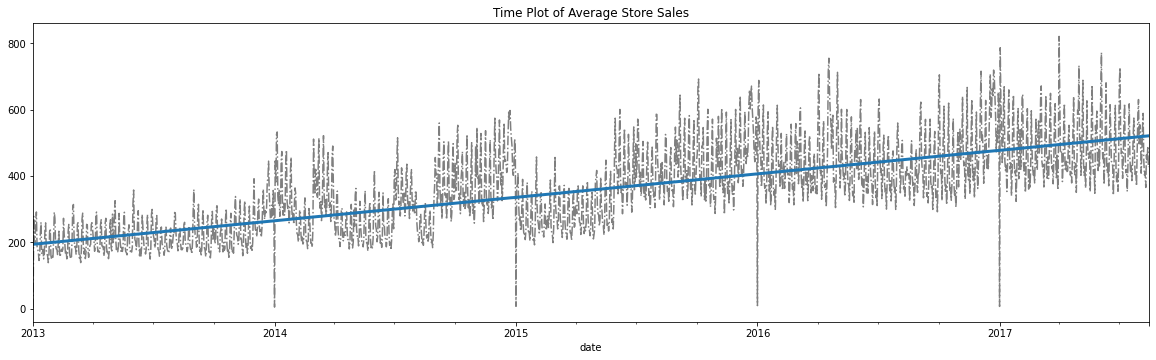

In [16]:
fig, ax = plt.subplots(figsize=(20, 5.5), sharex=True)
ax = y.plot(alpha=0.5, linestyle='-.', color='black')
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Average Store Sales')

In [13]:
df['1st_lag'] = df['sales'].shift(1)

In [17]:
df.head()

,sales,time,1st_lag
date,,,
2013-01-01,1.409438,0,NaN
2013-01-02,278.390808,1,1.409438
2013-01-03,202.840195,2,278.390808
2013-01-04,198.911148,3,202.840195
2013-01-05,267.873230,4,198.911148


In [18]:
X = df.loc[:, ['1st_lag']]
X.dropna(inplace=True)
y = df.loc[:, 'sales']
y, X = y.align(X, join='inner')

In [19]:
model2 = LinearRegression()

model2.fit(X, y)

y_pred = pd.Series(model2.predict(X), index=X.index)

[Text(0, 0.5, 'sales'),
 Text(0.5, 0, '1st_lag'),
 Text(0.5, 1.0, 'Lag Plot of Average Sales'),
 None]

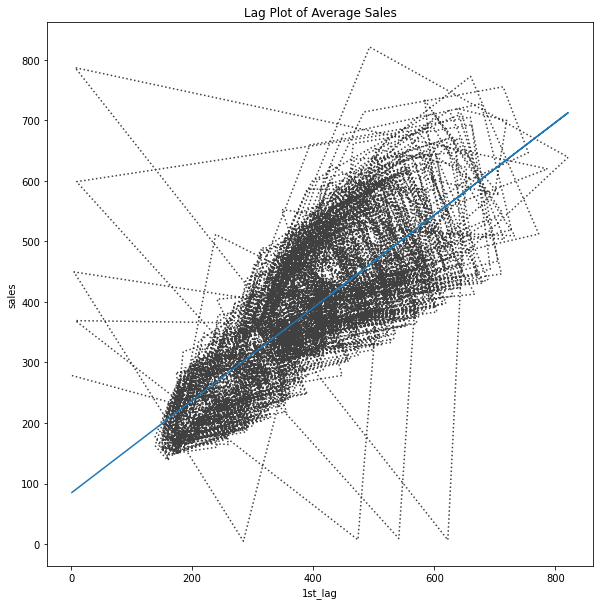

In [20]:
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
ax.plot(X['1st_lag'], y, linestyle='dotted', color='0.25')
ax.plot(X['1st_lag'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='1st_lag', title='Lag Plot of Average Sales')

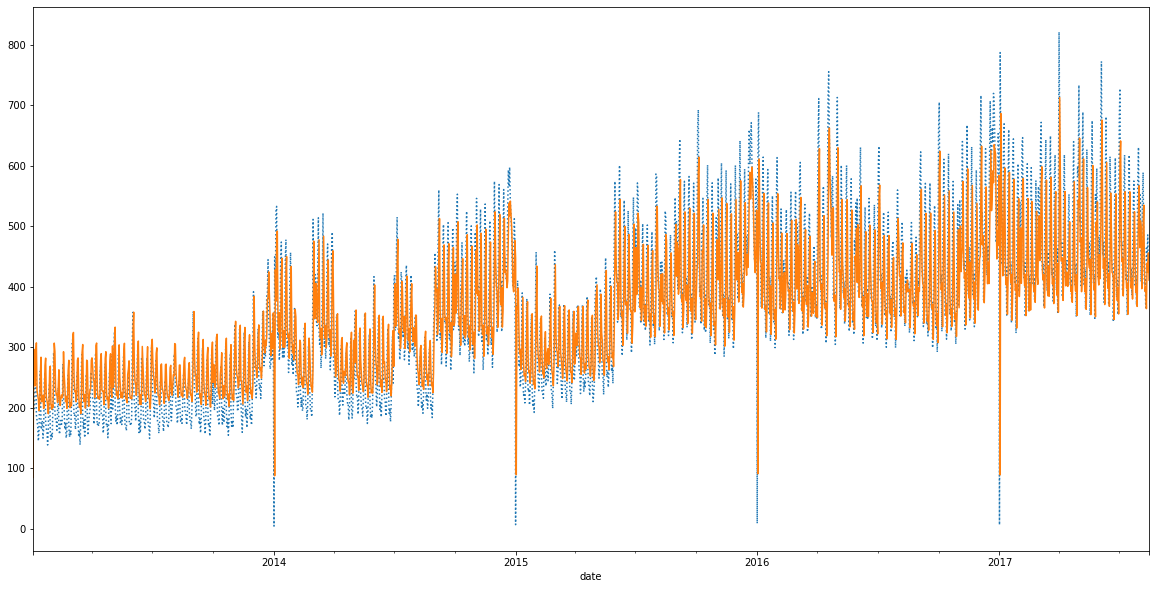

In [29]:
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
ax = y.plot(linestyle='dotted')
ax = y_pred.plot()

In [21]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [30]:
y = average_sales.copy()

In [56]:
dp = DeterministicProcess(index=y.index, order=5)

In [67]:
X = dp.in_sample()

X_forecast = dp.out_of_sample(steps=90)

In [68]:
model3 = LinearRegression()

model3.fit(X, y)

y_pred = pd.Series(model3.predict(X), index=X.index)
y_forecast = pd.Series(model3.predict(X_forecast), index=X_forecast.index)

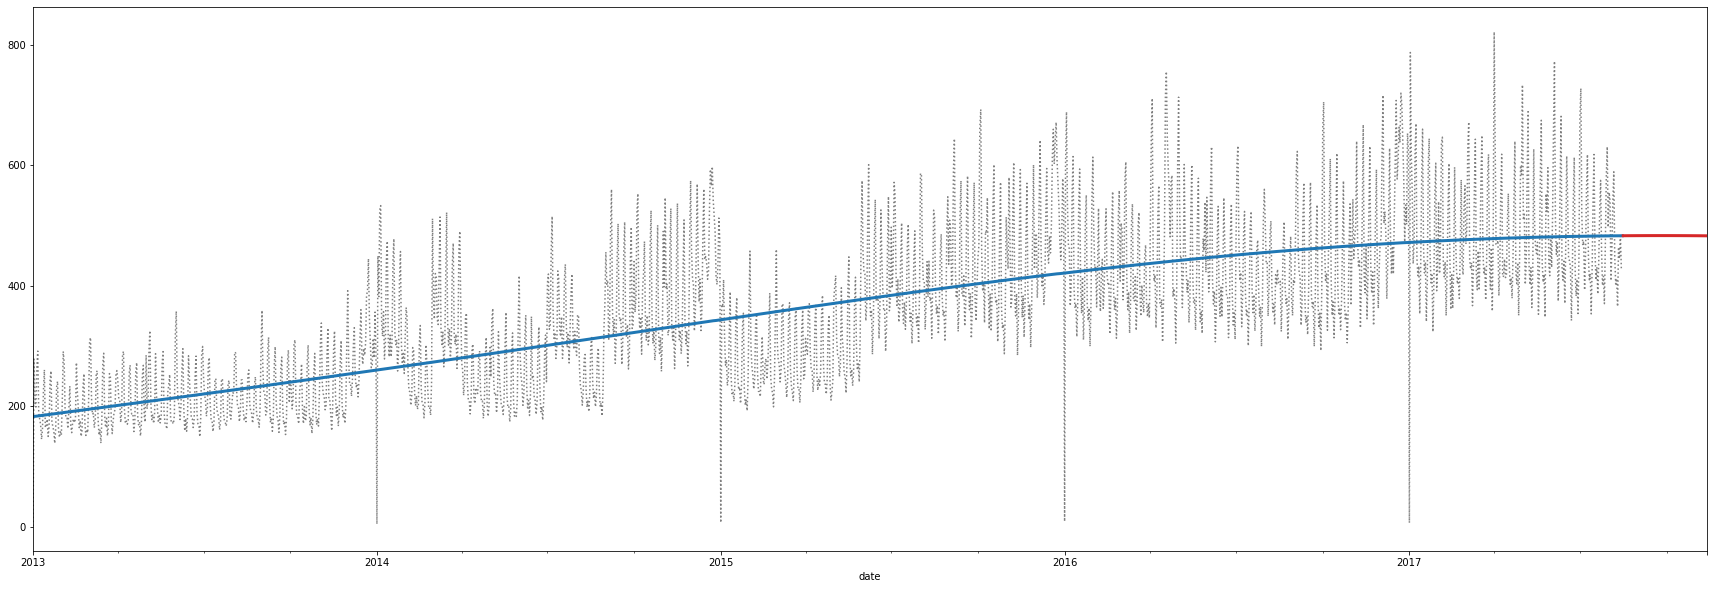

In [69]:
fig, ax = plt.subplots(figsize=(30, 10))

ax = y.plot(linestyle='dotted', alpha=.5, color='black')
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')



In [60]:
trend = average_sales.rolling(window=12, center=True, min_periods=6).mean()


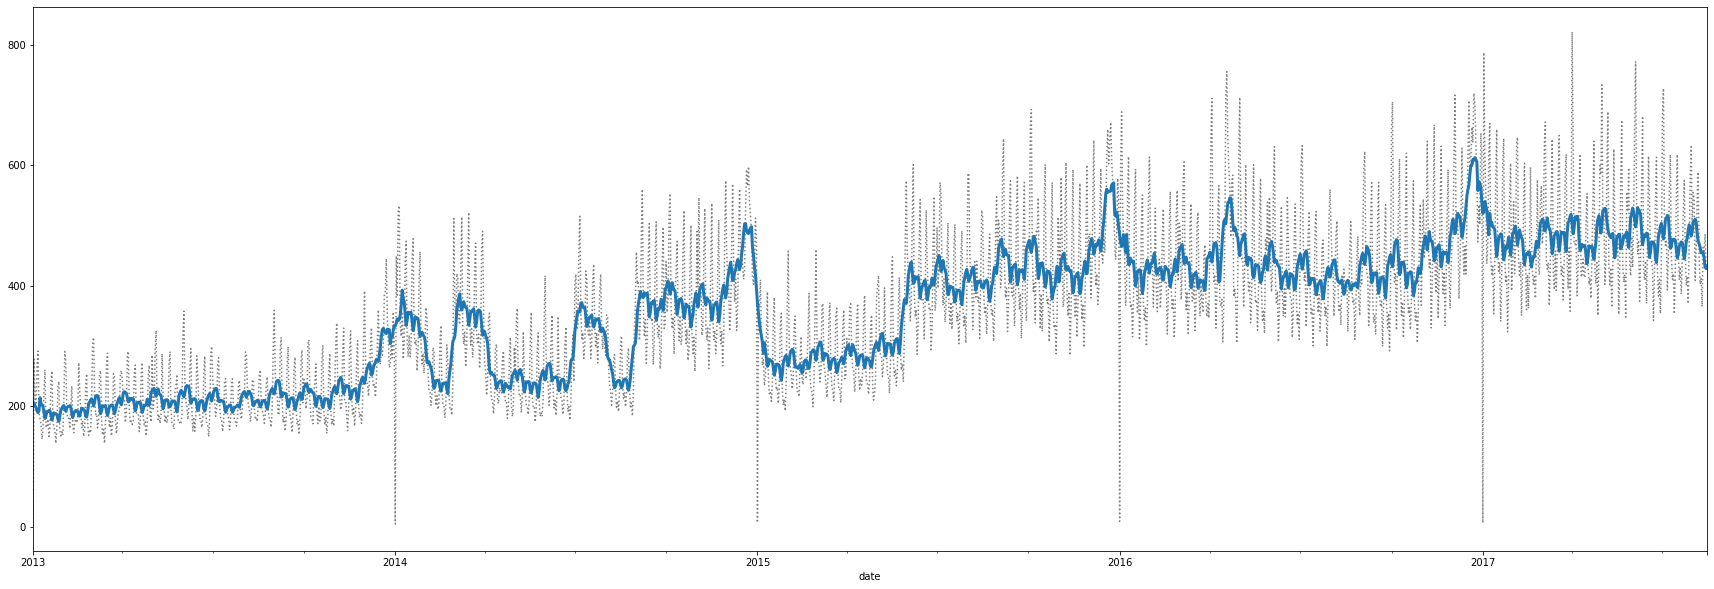

In [66]:
fig, ax = plt.subplots(figsize=(30, 10))
ax = average_sales.plot(alpha=.5, color='black', linestyle='dotted')

ax = trend.plot(ax=ax, linewidth=3)